<h1> Credit Card Fraud Detection</h1>

# Anomaly Detection using Isolation Forest

## Overview
This project implements the **Isolation Forest** algorithm for anomaly detection in a dataset. The Isolation Forest algorithm is designed to identify outliers by isolating observations through a series of random splits.

## Isolation Forest Algorithm

The **Isolation Forest** algorithm is an unsupervised learning method used for anomaly detection. It constructs an ensemble of decision trees (i.e., "forest") and isolates observations by randomly selecting a feature and splitting it into random intervals. Anomalies, which are rare or distinct from the normal data points, tend to get isolated early in this process, resulting in shorter paths to isolation compared to normal points.

### Key Features of the Algorithm:
- **Anomaly Detection**: Designed specifically to identify outliers, making it suitable for problems like fraud detection or rare event identification.
- **Efficiency**: Works well on large datasets as it scales linearly with the number of data points and dimensions.
- **Interpretability**: Points are classified as anomalies based on how quickly they are isolated. The shorter the path to isolation, the more likely it is an outlier.

### Effectiveness:
The Isolation Forest is particularly effective because it:
- Does not rely on distance measures, making it robust for high-dimensional data.
- Can detect anomalies in both small and large datasets with minimal tuning, such as adjusting the contamination parameter (the expected proportion of anomalies).
- Handles unscaled data well, though scaling can sometimes improve performance.

This algorithm is widely used in domains like fraud detection, network intrusion detection, and industrial equipment monitoring, where anomalies can indicate critical issues.

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [3]:
data = pd.read_csv('creditcard.csv')
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

<h2> 1. Data Preprocessing</h2>
<h3> Handling Seasonal Variations </h3>
<br>
We will assume that the Time column represents the time in seconds since the first transaction. To handle seasonal variations, we will convert the Time into more meaningful periods like hours or days. Then, we will decompose the data into seasonal, trend, and residual components using seasonal decomposition.

In [4]:
data['Hour'] = data['Time'] // 3600  # Time in hours

# Decompose the 'Amount' column into trend, seasonal, and residual components
result = seasonal_decompose(data['Amount'], model='additive', period=24)  # Adjust period as needed
data['Residual'] = result.resid.fillna(0)  # Use the residual for anomaly detection

<h1>Manually written code for isolation forest</h1>

In [7]:
class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit
        self.split_value = None
        self.split_feature = None
        self.left = None
        self.right = None
        self.is_leaf = False
        self.size = 0

    def fit(self, X, current_height):
        if current_height >= self.height_limit or len(X) <= 1:
            self.is_leaf = True
            self.size = len(X)
            return
        
        # Randomly select a feature to split
        self.split_feature = random.choice(X.columns)
        
        # Randomly select a split value between the min and max of the selected feature
        min_val = X[self.split_feature].min()
        max_val = X[self.split_feature].max()
        if min_val == max_val:
            self.is_leaf = True
            self.size = len(X)
            return
        
        self.split_value = random.uniform(min_val, max_val)
        
        # Split the dataset into two based on the split_value
        left_X = X[X[self.split_feature] < self.split_value]
        right_X = X[X[self.split_feature] >= self.split_value]
        
        # Create child nodes
        self.left = IsolationTree(self.height_limit)
        self.right = IsolationTree(self.height_limit)
        
        # Recursively fit on the left and right branches
        self.left.fit(left_X, current_height + 1)
        self.right.fit(right_X, current_height + 1)

class IsolationForest:
    def __init__(self, n_trees=100, subsample_size=256):
        self.n_trees = n_trees
        self.subsample_size = subsample_size
        self.trees = []
        self.height_limit = np.ceil(np.log2(subsample_size))

    def fit(self, X):
        for _ in range(self.n_trees):
            subsample = X.sample(min(self.subsample_size, len(X)), replace=False)
            tree = IsolationTree(self.height_limit)
            tree.fit(subsample, current_height=0)
            self.trees.append(tree)
    
    def path_length(self, X, tree):
        if tree.is_leaf:
            return np.log(tree.size + 1)
        
        if X[tree.split_feature] < tree.split_value:
            return 1 + self.path_length(X, tree.left)
        else:
            return 1 + self.path_length(X, tree.right)
    
    def anomaly_score(self, X):
        avg_path_length = np.mean([self.path_length(X, tree) for tree in self.trees])
        return 2 ** (-avg_path_length / self.height_limit)
    
    def predict(self, X):
        scores = []
        for i in range(len(X)):
            score = self.anomaly_score(X.iloc[i])
            scores.append(score)
        
        # Return 1 for normal, -1 for anomaly based on a threshold
        return [-1 if score > 0.5 else 1 for score in scores]

<h2>2. Train Isolation Forest Model</h2>
We will use the residual (after seasonal decomposition) to train the Isolation Forest.

In [21]:
data['Hour'] = data['Time'] // 3600

# Decompose 'Amount' to get residuals
result = seasonal_decompose(data['Amount'], model='additive', period=24)
data['Residual'] = result.resid.fillna(0)

# Select features to be used for isolation forest (Amount and Residual)
features = data[['Amount', 'Residual']]

# Initialize and fit Isolation Forest (without standardizing the data)
iso_forest = IsolationForest(contamination=0.0004, random_state=42)
data['Anomaly'] = iso_forest.fit_predict(features)


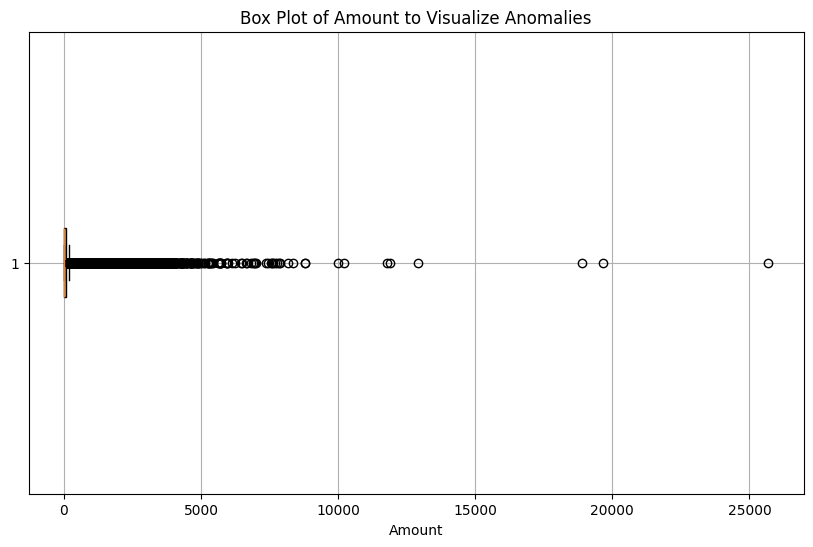

In [25]:
import matplotlib.pyplot as plt

# Create a box plot for the 'Amount' column to visualize outliers
plt.figure(figsize=(10, 6))
plt.boxplot(data['Amount'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'))

# Customize the plot
plt.title('Box Plot of Amount to Visualize Anomalies')
plt.xlabel('Amount')

# Display the box plot
plt.grid(True)
plt.show()


<h2>Plotting the Results</h2>

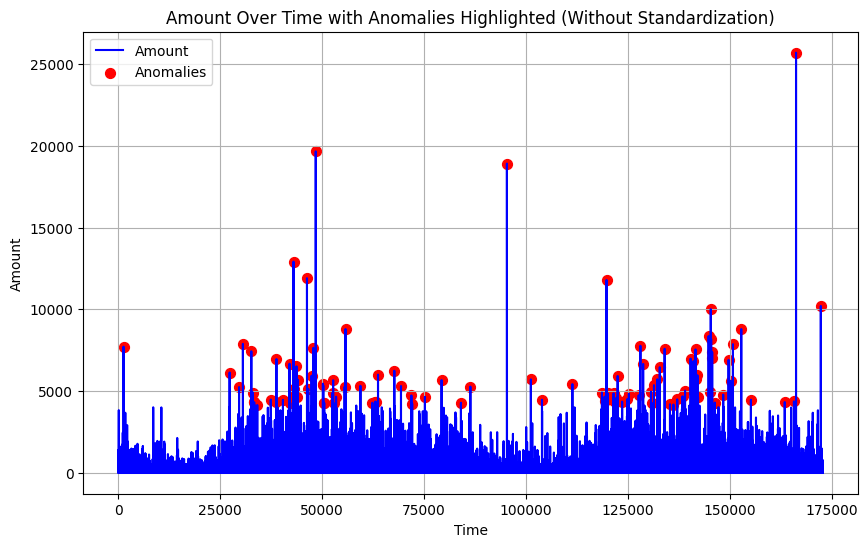

In [22]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot 'Amount' and highlight anomalies
plt.plot(data['Time'], data['Amount'], label='Amount', color='blue')
plt.scatter(data[data['Anomaly'] == -1]['Time'], data[data['Anomaly'] == -1]['Amount'], 
            color='red', label='Anomalies', s=50)

plt.title('Amount Over Time with Anomalies Highlighted (Without Standardization)')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()